# Data creation with minimal exploration


In [1]:
#audio
from __future__ import print_function
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import ffmpeg
import librosa
import librosa.display

In [2]:
import pandas as pd 
import pyloudnorm as pyln

In [3]:
#video
import moviepy
from moviepy.editor import *

In [4]:
#importing audio
#x1 waveform 
#fs sampling rate

In [5]:
AUDIO_VIDEO_TUPLE_LIST=[("E2 - Chukwu.mp3", 1), ("E2 - Osi.mp3", 1),("E2 - Crystal.mp3",2),("E2 - Scott.mp3",2)]
VIDEO_FILEPATH_LIST= ["Hang out 2 Middle.mp4","Hang out 2 Left.mp4","Hang out 2 Right.mp4"]

In [6]:
type(AUDIO_VIDEO_TUPLE_LIST[0])

tuple

## Creating Data for each Microphone


In [7]:
#importing video and its audio
def dataframecreation(file_dir_list,rate):
    df_list=[]
    instance=1
    for file_dir in file_dir_list:
        if type(file_dir)==tuple:
            print(file_dir[0])
            data1, rate1 = librosa.load(file_dir[0], sr=48000) 
            data= librosa.resample(data1, orig_sr=rate1, target_sr=rate, scale=True)

            # peak normalize audio to -1 dB
            peak_normalized_audio = pyln.normalize.peak(data, -1.0)

            # measure the loudness first 
            meter = pyln.Meter(rate) # create BS.1770 meter
            loudness = meter.integrated_loudness(data)

            # loudness normalize audio to -12 dB LUFS
            audio_data_df = pd.DataFrame(pyln.normalize.loudness(data, loudness, -20.0)).rename(columns={0:str(instance)})
            df_list.append(audio_data_df)
            instance=instance+1    
            
        else:
            data1, rate1 = librosa.load(file_dir, sr=48000) 
            data= librosa.resample(data1, orig_sr=rate1, target_sr=rate, scale=True)

            # peak normalize audio to -1 dB
            peak_normalized_audio = pyln.normalize.peak(data, -1.0)

            # measure the loudness first 
            meter = pyln.Meter(rate) # create BS.1770 meter
            loudness = meter.integrated_loudness(data)

            # loudness normalize audio to -12 dB LUFS
            audio_data_df = pd.DataFrame(pyln.normalize.loudness(data, loudness, -20.0)).rename(columns={0:str(instance)})
            df_list.append(audio_data_df)
            instance=instance+1
    return(df_list)

In [8]:
def doublerollingaverage1(df_list,rate):
    dra_df_list=[]
    for df in df_list:
        indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=2*rate)
        rollingaverage_df=df.abs().rolling(indexer).mean()
        Drollingaverage_df=rollingaverage_df.abs().rolling(rate*5,center=True).mean()
        dra_df_list.append(Drollingaverage_df)
    return dra_df_list

In [9]:
def doublerollingaverage(df_list,rate):
    dra_df_list=[]
    for df in df_list:
        rollingaverage_df=df.abs().rolling(rate*5,center=True).mean()
        Drollingaverage_df=rollingaverage_df.abs().rolling(rate*5,center=True).mean()
        dra_df_list.append(Drollingaverage_df)
    return dra_df_list

In [10]:
rate=500 #samples per sec

In [11]:
df_list=dataframecreation(AUDIO_VIDEO_TUPLE_LIST,rate)


E2 - Chukwu.mp3
E2 - Osi.mp3
E2 - Crystal.mp3
E2 - Scott.mp3


In [12]:
dra_df_list=doublerollingaverage(df_list,rate)

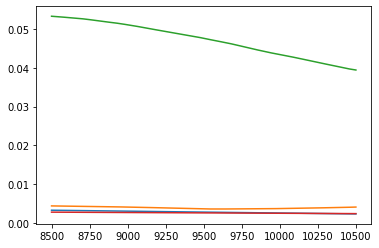

In [13]:
fig = plt.figure()
for frame in dra_df_list:
    plt.plot(frame[17*rate:21*rate])



In [14]:
dra_df_list[0].loc[175.6*rate]

1    0.007164
Name: 87800, dtype: float64

In [15]:
175*rate

87500

# Testing the logics, Creating speaking intervals

In [16]:
import dtale

In [17]:
#combine dfs first
combined_df=pd.concat(dra_df_list,axis=1)
#this why sync is important so that the rows are exactly aligned

In [18]:
range(len(combined_df.loc[10000].values))

range(0, 4)

In [19]:
#create list of string to call for each audio file. Used to call the audio name
list_str_audio_thresholds=[]

#for each audio element, create a new list "A{i}" and put that into a list
#each audio file is identified by its place in the tuple
for irow in range(len(AUDIO_VIDEO_TUPLE_LIST)):
    varname="A"
    exec(f"{varname}{irow} = []")
    
    
    list_str_audio_thresholds.append(varname+str(irow))

# testing

In [ ]:
frames_list=[]
largestindex_list=[]
crossover_list=[]
high_multiplethreshold_list=[]
similarloudness_list=[]
low_multiplethreshold_list=[]
for irow in range(len(combined_df)):
    #creating variables to call

    #more efficient to call variable than constant function calling
    nlargest=combined_df.loc[irow].nlargest(2)
    idxmax=combined_df.loc[irow].idxmax()
    values=combined_df.loc[irow].values
    if irow !=0:
        prev_idxmax=combined_df.loc[irow-1].idxmax()
    
    if pd.notna(combined_df.loc[irow].idxmax())==True:
        
        #largest value index
        frames_list.append(int(idxmax))
        
        #indicators
        
        #crossover
        if combined_df.loc[irow].idxmax() != combined_df.loc[irow-1].idxmax():
            crossover_list.append(1)
        else:
            crossover_list.append(0)
            
            
        # multiple above threshold .035
        if nlargest[1]> .035:
            high_multiplethreshold_list.append(1)
        else:
            high_multiplethreshold_list.append(0)

        #all below threshold .035
        if nlargest[0]< .035:
            low_multiplethreshold_list.append(1)
        else:
            low_multiplethreshold_list.append(0)
        
        #similar loudness
        if nlargest[0]-nlargest[1] <.007:
            similarloudness_list.append(1)
        else:
            similarloudness_list.append(0)
            
#=======audio threshold  ===================================================================  
        for ix in range(len(values)):
            if values[ix]>.0063 :
                eval(list_str_audio_thresholds[ix]).append(1)

            else:
                eval(list_str_audio_thresholds[ix]).append(0)
    else:
        frames_list.append(0)
        crossover_list.append(0)
        high_multiplethreshold_list.append(0)
        similarloudness_list.append(0)
        low_multiplethreshold_list.append(0)
        
        for ix in range(len(values)):
            if values[ix]>.0085 :
                eval(list_str_audio_thresholds[ix]).append(1)

            else:
                eval(list_str_audio_thresholds[ix]).append(0)
#if there is another crossover within  6 secs after crossover, maintain center cam 

 


In [ ]:
test=pd.DataFrame({"idxmax":frames_list,"crossover":crossover_list,"high_mult_thresh":high_multiplethreshold_list,"low_mult_thresh":low_multiplethreshold_list,"nearnesssound":similarloudness_list})

In [ ]:
#add a column for each audio file in the list 
#use the loop to add the corresponding threshold data
#eval uses string to call the threshold list
for i in range(len(list_str_audio_thresholds)):
    test[list_str_audio_thresholds[i]]=eval(list_str_audio_thresholds[i])

In [ ]:
#create an empty column
test["Main_cam"]=0

#if crossover, change that row and all the rows three seconds after to 1
for i in range(len(test['crossover'])):
    if test['crossover'][i]==1:
        test["Main_cam"][i-rate:i+rate*5]=1


In [ ]:
combined_df.loc[rate*18]

In [ ]:
combined_df.mean().mean()

In [ ]:
test.to_pickle("idxmax.pkl")